# Cross-lingual Semantic Textual Similarity

In [79]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import torch
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM
from datasets import load_dataset

from util import encode_batch

In [4]:
# 1- load the model the tokenizer
hf_model_id = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
model = AutoModel.from_pretrained(hf_model_id)

_ = model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
langs = ['en', 'de', 'es', 'fr', 'it', 'nl', 'pl', 'pt', 'ru', 'zh']

In [6]:
datasets = {}
for l in langs:
    datasets[l] = load_dataset("stsb_multi_mt", name=l, split="dev")

Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/de/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/es/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/it/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/nl/1.0.0/a5d260e4b7aa82d1ab7379

In [7]:
en_pivot = datasets['en'].map(function=encode_batch, fn_kwargs={'field': 'sentence1', 'tokenizer': tokenizer, 'model': model},
                              batched=True,
                              batch_size=3000)

for l in langs:
    datasets[l] = datasets[l].map(function=encode_batch, 
                                  fn_kwargs={'field': 'sentence2', 'tokenizer': tokenizer, 'model': model},
                                  batched=True,
                                  batch_size=3000)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
from scipy import spatial, stats

In [10]:
y_gold = [s / 5. for s in en_pivot['similarity_score']]

In [11]:
num_layers = 13

def sts_spearman(reps1, reps2):
    res = []
    for s, t in zip(reps1, reps2):
        res.append(1 - spatial.distance.cosine(s, t))
    return stats.spearmanr(res, y_gold).correlation, res

In [50]:
from collections import defaultdict

In [53]:
%%time

cls_spearman = defaultdict(list)
mean_spearman = defaultdict(list)

cls_cos = defaultdict(list)
mean_cos = defaultdict(list)


for l in ['en', 'fr']:#langs:
    print(l)
    for j in range(num_layers):
        corr, cos = sts_spearman(en_pivot[f'cls_{j}'], datasets[l][f'cls_{j}'])
        cls_spearman[l].append(corr)
        cls_cos[l].append(cos)
        
        corr, cos = sts_spearman(en_pivot[f'mean_{j}'], datasets[l][f'mean_{j}'])
        mean_spearman[l].append(corr)
        mean_cos[l].append(cos)
        

en
fr
CPU times: user 57.6 s, sys: 1.48 s, total: 59 s
Wall time: 59 s


### Plot correlation with English

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

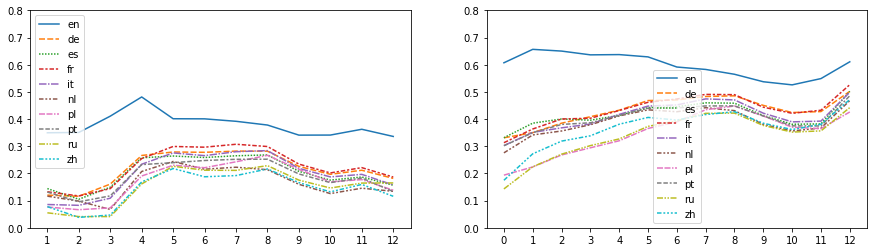

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

ax[0].set_ylim([0,0.8])
ax[0].set(xticks=list(range(13)))

ax[1].set_ylim([0,0.8])
ax[1].set(xticks=list(range(13)))

sns.lineplot(data=pd.DataFrame(cls_spearman), ax=ax[0])
sns.lineplot(data=pd.DataFrame(mean_spearman), ax=ax[1])


In [15]:
df_mean_spearman = pd.DataFrame(mean_spearman)
df_cls_spearman = pd.DataFrame(cls_spearman)

In [16]:
df_cls_spearman["cl avg"] = df_cls_spearman.loc[:, df_cls_spearman.columns != 'en'].mean(axis=1)
df_mean_spearman["cl avg"] = df_mean_spearman.loc[:, df_mean_spearman.columns != 'en'].mean(axis=1)

In [17]:
xling = {"xling_cls": df_cls_spearman["cl avg"], "xling_mean": df_mean_spearman["cl avg"]}
en = {"en_cls": df_cls_spearman["en"], "en_mean": df_mean_spearman["en"]}

<AxesSubplot:>

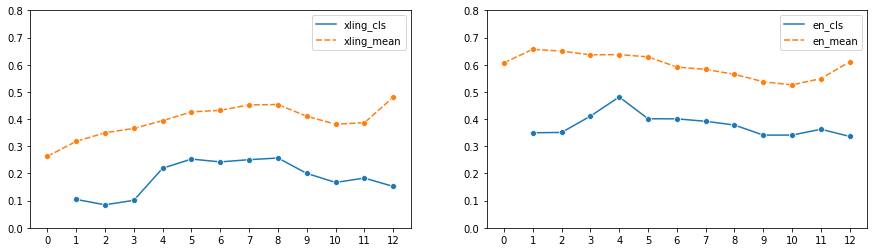

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

ax[0].set_ylim([0,0.8])
ax[0].set(xticks=list(range(13)))

ax[1].set_ylim([0,0.8])
ax[1].set(xticks=list(range(13)))

sns.lineplot(data=pd.DataFrame(xling), ax=ax[0], marker='o')
sns.lineplot(data=pd.DataFrame(en), ax=ax[1], marker='o')


### Plot cosine similarity

In [54]:
y_gold = [s / 5. for s in en_pivot['similarity_score']]

In [55]:
import numpy as np

In [56]:
sort_idx = np.argsort(y_gold).tolist()

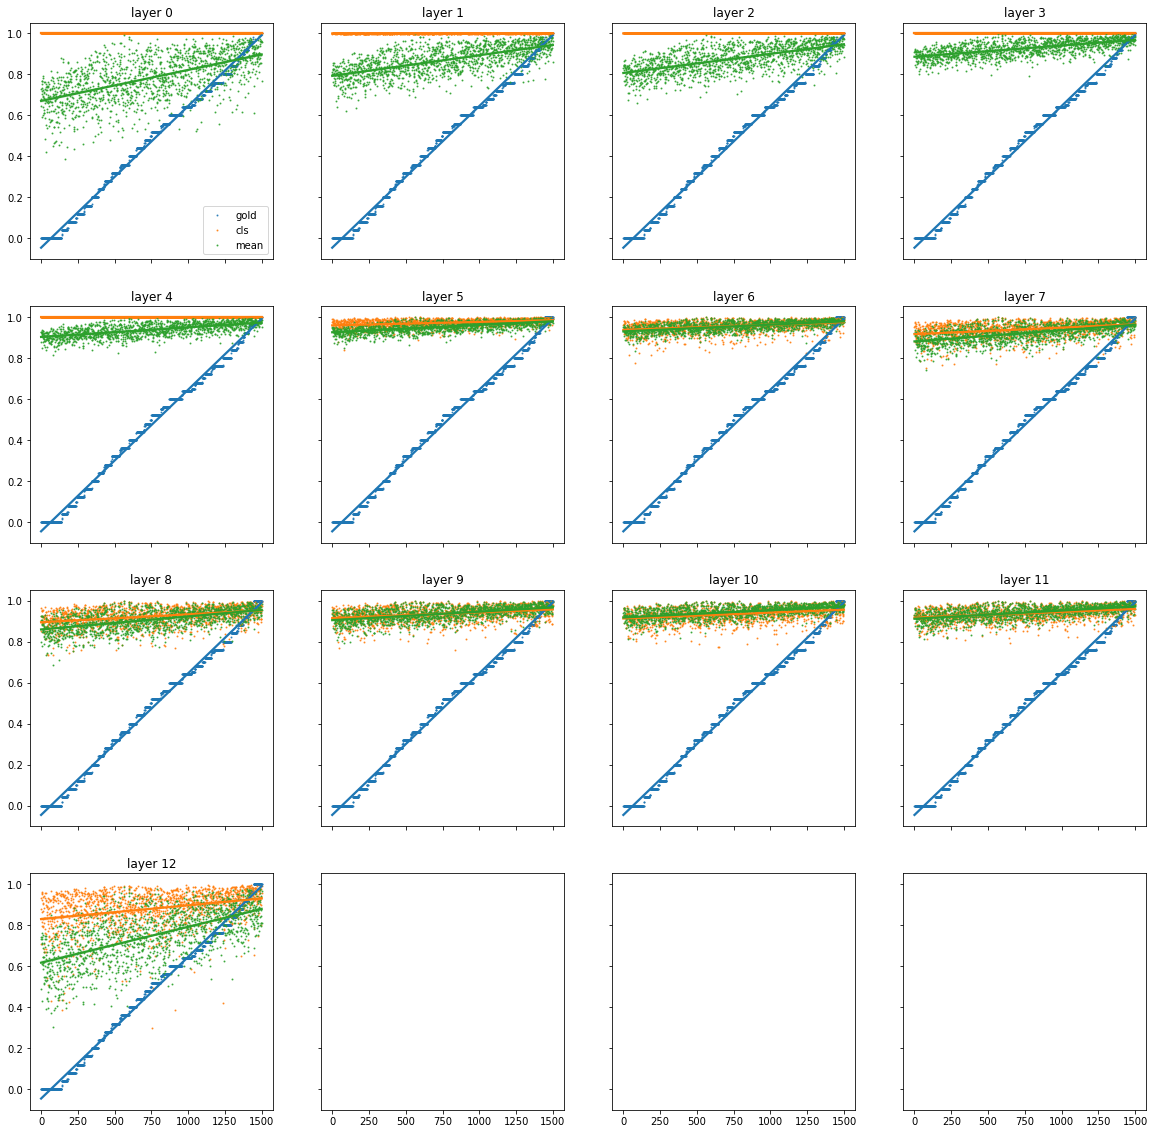

In [57]:
fig, ax = plt.subplots(4,4, figsize=(20,20), sharex=True, sharey=True)

lang='en'

for i in range(4):
    for j in range(4):
        layer = i*4 + j
        
        if layer > 12:
            break
            
        ax[i,j].set_title(f"layer {layer}")

        sns.regplot(x=list(range(1500)),
                    y=sorted(y_gold),
                    scatter_kws={'s':1},
                    ax=ax[i,j],
                    label="gold")

        sns.regplot(x=list(range(1500)),
                    y=np.array(cls_cos[lang][layer])[sort_idx],
                    scatter_kws={'s':1},
                    ax=ax[i,j],
                    label="cls")

        sns.regplot(x=list(range(1500)), 
                    y=np.array(mean_cos[lang][layer])[sort_idx], 
                    scatter_kws={'s':1},
                    ax=ax[i,j],
                    label="mean")
        
        
        if layer == 0:
            ax[i,j].legend()

In [61]:
mean_cos['en'][12]

[0.9653265569522245,
 0.9533952888216746,
 0.8314129395671528,
 0.9040313166878902,
 0.9004517606978525,
 0.9388509145248739,
 0.7478000789076714,
 0.9104075236911252,
 0.9401135298732146,
 0.933878484404606,
 0.7687481368496445,
 0.9302255457865947,
 0.7811911711541466,
 0.8018343153819121,
 0.8081316160662487,
 0.8115831669055537,
 0.9309438026439503,
 0.9090451990020716,
 0.9035841881587405,
 0.7663502585205212,
 0.789572102913917,
 0.9350456485793882,
 0.8269631573493608,
 0.9068916381935995,
 0.7510209655764641,
 0.9422294605795591,
 0.838744974598848,
 0.8418033737521677,
 0.6726712101171659,
 0.7801234174156948,
 0.8119904327970088,
 0.88589877168819,
 0.8357352989285075,
 0.8851572230914895,
 0.8667040853540072,
 0.7935809089351852,
 0.8831802667506359,
 0.8800750536666915,
 0.8811339378027686,
 0.8488450995969694,
 0.9057563001208913,
 0.8258860617107326,
 0.7299240295558521,
 0.8495329624218417,
 0.866875769426895,
 0.7170527106513532,
 0.7871129702672294,
 0.7145138294277155

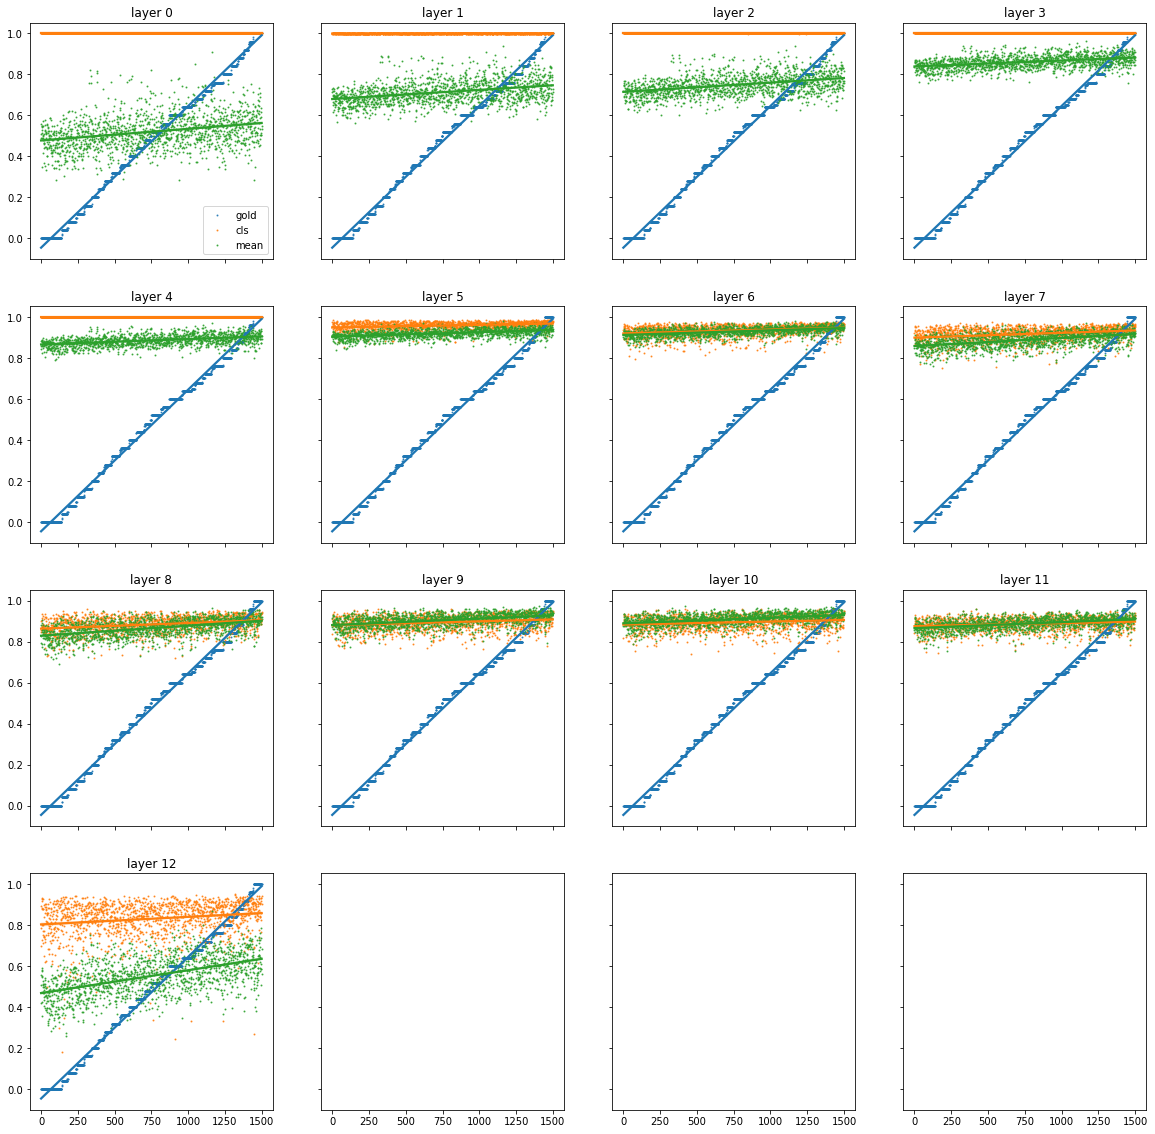

In [23]:
fig, ax = plt.subplots(4,4, figsize=(20,20), sharex=True, sharey=True)

lang='fr'

for i in range(4):
    for j in range(4):
        layer = i*4 + j
        
        if layer > 12:
            break
            
        ax[i,j].set_title(f"layer {layer}")

        sns.regplot(x=list(range(1500)),
                    y=sorted(y_gold),
                    scatter_kws={'s':1},
                    ax=ax[i,j],
                    label="gold")

        sns.regplot(x=list(range(1500)),
                    y=np.array(cls_cos[lang][layer])[sort_idx],
                    scatter_kws={'s':1},
                    ax=ax[i,j],
                    label="cls")

        sns.regplot(x=list(range(1500)), 
                    y=np.array(mean_cos[lang][layer])[sort_idx], 
                    scatter_kws={'s':1},
                    ax=ax[i,j],
                    label="mean")
        
        
        if layer == 0:
            ax[i,j].legend()

### Plot Representational SImilarities

In [62]:
mean_cos['en'][12]

[0.9653265569522245,
 0.9533952888216746,
 0.8314129395671528,
 0.9040313166878902,
 0.9004517606978525,
 0.9388509145248739,
 0.7478000789076714,
 0.9104075236911252,
 0.9401135298732146,
 0.933878484404606,
 0.7687481368496445,
 0.9302255457865947,
 0.7811911711541466,
 0.8018343153819121,
 0.8081316160662487,
 0.8115831669055537,
 0.9309438026439503,
 0.9090451990020716,
 0.9035841881587405,
 0.7663502585205212,
 0.789572102913917,
 0.9350456485793882,
 0.8269631573493608,
 0.9068916381935995,
 0.7510209655764641,
 0.9422294605795591,
 0.838744974598848,
 0.8418033737521677,
 0.6726712101171659,
 0.7801234174156948,
 0.8119904327970088,
 0.88589877168819,
 0.8357352989285075,
 0.8851572230914895,
 0.8667040853540072,
 0.7935809089351852,
 0.8831802667506359,
 0.8800750536666915,
 0.8811339378027686,
 0.8488450995969694,
 0.9057563001208913,
 0.8258860617107326,
 0.7299240295558521,
 0.8495329624218417,
 0.866875769426895,
 0.7170527106513532,
 0.7871129702672294,
 0.7145138294277155

In [63]:
2+2

4

In [64]:
from ecco import analysis

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
sort_idx = np.argsort(y_gold).tolist()

In [67]:
np.concatenate([reps1, reps2]).shape

(1500, 768)

In [68]:
def feature_space_linear_cka(features_x, features_y, debiased=False, avg=True):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """

  if avg:
    
#     mu1 = np.mean(np.concatenate([features_x, features_y]), 0, keepdims=True)
#     mu2 = mu1

    mu1 = np.mean(features_x, 0, keepdims=True)
    mu2 = np.mean(features_y, 0, keepdims=True)
    
    features_x = features_x - mu1
    features_y = features_y - mu2

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  print(f"dot prod sim {dot_product_similarity}")
    
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))
  
  print(f"normalization_x {normalization_x}", f"normalization_y {normalization_y}", f"mult {normalization_x * normalization_y}")
    
  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

0
dot prod sim 12030709.119577276
normalization_x 5075.802743183524 normalization_y 4503.81139261613 mult 22860458.221422166
1
dot prod sim 22117798.645347685
normalization_x 7083.007282702197 normalization_y 5788.773852870149 mult 41001927.35779532
2
dot prod sim 23476458.706111245
normalization_x 6873.496052335061 normalization_y 5807.863138361437 mult 39920324.354029655
3
dot prod sim 29672946.982149284
normalization_x 7334.261778563331 normalization_y 6442.579615614204 mult 47251565.430150494
4
dot prod sim 39937038.515247226
normalization_x 8231.106730590249 normalization_y 7273.1318480485315 mult 59865924.50694256
5
dot prod sim 51523279.329843216
normalization_x 9177.410826417794 normalization_y 7878.505363420896 mult 72304280.41824959
6
dot prod sim 144145085.9088173
normalization_x 15190.427820028968 normalization_y 12941.672706787904 mult 196589545.12290058
7
dot prod sim 189429970.42747065
normalization_x 17099.669847339504 normalization_y 15472.336922186752 mult 264571853.1

(0.0, 1.0)

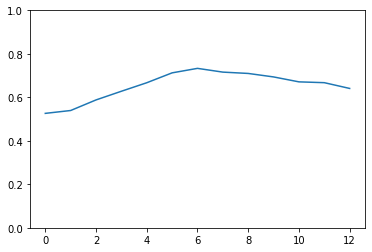

In [69]:
lang='en'
r = []
for j in range(13):
    print(j)
    
    reps1 = np.array(en_pivot[f'mean_{j}'])[sort_idx][0:1500]
    reps2 = np.array(datasets[l][f'mean_{j}'])[sort_idx][0:1500]
    #np.random.shuffle(reps2)
    #score = analysis.cka(reps1.T, reps2.T)
    score = feature_space_linear_cka(reps1, reps2, avg=True)
    r.append(score)
    
sns.lineplot(data=r)
plt.ylim(0,1)

In [72]:
import numpy as np

def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not np.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    np.fill_diagonal(gram, 0)
    means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
    means -= np.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    np.fill_diagonal(gram, 0)
  else:
    means = np.mean(gram, 0, dtype=np.float64)
    means -= np.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = np.linalg.norm(gram_x)
  normalization_y = np.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """
  features_x = features_x - np.mean(features_x, 0, keepdims=True)
  features_y = features_y - np.mean(features_y, 0, keepdims=True)

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))

  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

In [77]:
def run_cka(X, Y, debiased=False):
    return cka(gram_linear(X), gram_linear(Y), debiased=debiased)

0
1
2
3
4
5
6
7
8
9
10
11
12


(0.0, 1.0)

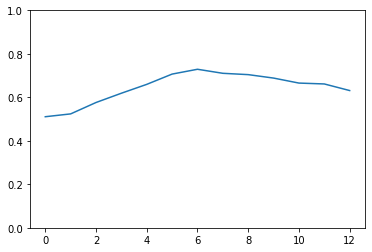

In [78]:
lang='en'
r = []
for j in range(13):
    print(j)
    
    reps1 = np.array(en_pivot[f'mean_{j}'])
    reps2 = np.array(datasets[l][f'mean_{j}'])
    #np.random.shuffle(reps2)
    #score = analysis.cka(reps1.T, reps2.T)
    score = run_cka(reps1, reps2, debiased=True)
    r.append(score)
    
sns.lineplot(data=r)
plt.ylim(0,1)

0
dot prod sim 2059800314.4591641
normalization_x 46740.35486455115 normalization_y 44870.89788505766 mult 2097281690.2386327
1
dot prod sim 17642720646.547306
normalization_x 131076.73607704815 normalization_y 135115.67357085104 mult 17710521484.51903
2
dot prod sim 17082232157.014166
normalization_x 129577.73300552058 normalization_y 132169.38180081523 mult 17126208866.490747
3
dot prod sim 57170683494.16711
normalization_x 239833.8914592515 normalization_y 238739.67575787872 mult 57257865482.73198
4
dot prod sim 90388270576.84125
normalization_x 298423.2152103081 normalization_y 303141.05446095206 mult 90464328134.48042
5
dot prod sim 154283672677.22772
normalization_x 390731.12734246155 normalization_y 395094.491558434 mult 154375716093.42355
6
dot prod sim 337009008318.1412
normalization_x 580689.3672291947 normalization_y 580786.5125626896 mult 337256552475.279
7
dot prod sim 180467518073.37668
normalization_x 424845.11298116704 normalization_y 425340.4109562339 mult 180703794948

<AxesSubplot:>

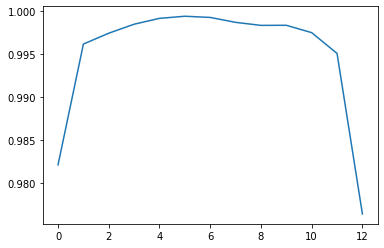

In [71]:
lang='en'
r = []
for j in range(13):
    print(j)
    
    reps1 = np.array(en_pivot[f'mean_{j}'])[sort_idx][0:1500]
    reps2 = np.array(datasets[l][f'mean_{j}'])[sort_idx][0:1500]
    #np.random.shuffle(reps2)
    #score = analysis.cka(reps1.T, reps2.T)
    score = feature_space_linear_cka(reps1, reps2, avg=False)
    r.append(score)
    
sns.lineplot(data=r)


0
dot prod sim 45178197.90146787
normalization_x 6963.284389059605 normalization_y 7086.568300448957 mult 49345790.41852088
1
dot prod sim 45825078.674327105
normalization_x 7134.9936832092635 normalization_y 7484.195054464956 mult 53399684.43751347
2
dot prod sim 28420015.23713017
normalization_x 5750.903764383942 normalization_y 5995.666031648459 mult 34480498.351396054
3
dot prod sim 22476578.051865663
normalization_x 5302.267823309865 normalization_y 5321.483212102294 mult 28215929.207813617
4
dot prod sim 25434127.52932354
normalization_x 5622.991377951556 normalization_y 5684.847034712306 mult 31965845.861160766
5
dot prod sim 23851119.40865524
normalization_x 5602.505068412344 normalization_y 5451.9353566982445 mult 30544495.46855838
6
dot prod sim 49936540.06934202
normalization_x 8585.190996041925 normalization_y 7711.71169518167 mult 66206517.80954488
7
dot prod sim 61019001.27268739
normalization_x 9455.873194101956 normalization_y 8905.654505531344 mult 84210739.71478714
8


(0.0, 1.0)

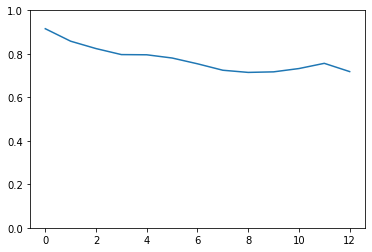

In [42]:
lang='en'
r = []
for j in range(13):
    print(j)
    
    reps1 = np.array(en_pivot[f'mean_{j}'])[sort_idx][0:750]
    reps2 = np.array(datasets[l][f'mean_{j}'])[sort_idx][0:750]
    #np.random.shuffle(reps2)
    #score = analysis.cka(reps1.T, reps2.T)
    score = feature_space_linear_cka(reps1, reps2, avg=True)
    r.append(score)
    
sns.lineplot(data=r)
plt.ylim(0,1)

0
dot prod sim 42026788.64401742
normalization_x 6724.19343306812 normalization_y 6798.08198924602 mult 45711618.26954675
1
dot prod sim 43372216.16033419
normalization_x 6913.846544968327 normalization_y 7179.1500259499135 mult 49635541.602723084
2
dot prod sim 26813666.703409553
normalization_x 5539.921265623372 normalization_y 5726.051507360363 mult 31721874.51368044
3
dot prod sim 21385159.83208513
normalization_x 5079.489090631709 normalization_y 5096.586104852434 mult 25888053.519063093
4
dot prod sim 24188478.650590684
normalization_x 5384.7269079805965 normalization_y 5446.5778381374685 mult 29328334.241429612
5
dot prod sim 22130729.9434348
normalization_x 5272.963148022261 normalization_y 5174.381973375911 mult 27284325.45940188
6
dot prod sim 45536403.27308506
normalization_x 8011.686508963968 normalization_y 7303.448433058492 mult 58512939.28004875
7
dot prod sim 56386886.51638391
normalization_x 8871.300716557964 normalization_y 8344.782676571142 mult 74029076.53818606
8
d

(0.0, 1.0)

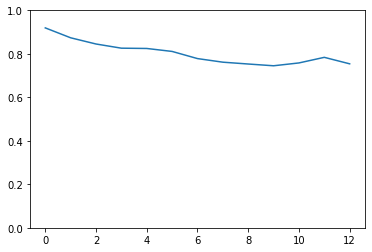

In [43]:
lang='en'
r = []
for j in range(13):
    print(j)
    
    reps1 = np.array(en_pivot[f'mean_{j}'])[sort_idx][750:1500]
    reps2 = np.array(datasets[l][f'mean_{j}'])[sort_idx][750:1500]
    #np.random.shuffle(reps2)
    #score = analysis.cka(reps1.T, reps2.T)
    score = feature_space_linear_cka(reps1, reps2, avg=True)
    r.append(score)
    
sns.lineplot(data=r)
plt.ylim(0,1)

0
dot prod sim 172515863.70376632
normalization_x 13619.452478096033 normalization_y 13816.65164715707 mult 188175230.51486298
1
dot prod sim 174893226.13050586
normalization_x 13930.729815829907 normalization_y 14538.883636245197 mult 202537259.7603225
2
dot prod sim 107725723.0175898
normalization_x 11176.67969479524 normalization_y 11601.617200643961 mult 129667559.39322457
3
dot prod sim 85307109.94953762
normalization_x 10263.392811473932 normalization_y 10312.57126452564 mult 105841969.7841451
4
dot prod sim 96389535.43854372
normalization_x 10875.722965210414 normalization_y 11016.290651715994 mult 119810125.23230043
5
dot prod sim 89048020.80435535
normalization_x 10740.207664105628 normalization_y 10503.40030855797 mult 112808700.49314372
6
dot prod sim 185025386.22403115
normalization_x 16413.961821429544 normalization_y 14852.42558550248 mult 243787146.51606107
7
dot prod sim 225458614.16547585
normalization_x 18065.774409733425 normalization_y 17014.583412036474 mult 307381

(0.0, 1.0)

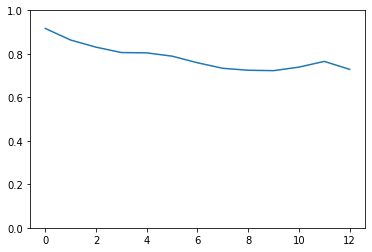

In [44]:
lang='en'
r = []
for j in range(13):
    print(j)
    
    reps1 = np.array(en_pivot[f'mean_{j}'])[sort_idx][0:1500]
    reps2 = np.array(datasets[l][f'mean_{j}'])[sort_idx][0:1500]
    #np.random.shuffle(reps2)
    #score = analysis.cka(reps1.T, reps2.T)
    score = feature_space_linear_cka(reps1, reps2, avg=True)
    r.append(score)
    
sns.lineplot(data=r)
plt.ylim(0,1)

0
dot prod sim 15831628.035460955
normalization_x 5075.802743183524 normalization_y 5357.4807798182055 mult 27193515.638754256
1
dot prod sim 33795757.729362644
normalization_x 7083.007282702197 normalization_y 8062.742055594564 mult 57108460.698325574
2
dot prod sim 32270217.559410386
normalization_x 6873.496052335061 normalization_y 7484.3212258862195 mult 51443452.40053643
3
dot prod sim 36008849.49863341
normalization_x 7334.261778563331 normalization_y 7407.11686664019 mult 54325734.12435093
4
dot prod sim 47959531.20773016
normalization_x 8231.106730590249 normalization_y 8426.962680531928 mult 69363229.2381592
5
dot prod sim 59769956.45693811
normalization_x 9177.410826417794 normalization_y 8920.581894219802 mult 81867844.85395937
6
dot prod sim 152762060.36094964
normalization_x 15190.427820028968 normalization_y 13586.097418382516 mult 206378632.1898215
7
dot prod sim 197578599.01162302
normalization_x 17099.669847339504 normalization_y 16063.73503591765 mult 274684565.629332

(0.0, 1.0)

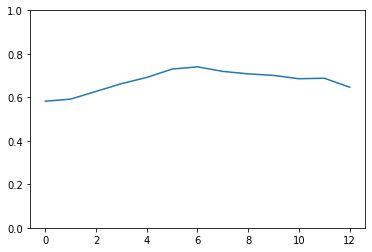

In [46]:
lang='en'
r = []
for j in range(13):
    print(j)
    
    reps1 = np.array(en_pivot[f'mean_{j}'])[sort_idx][0:1500]
    reps2 = np.array(datasets[l][f'mean_{j}'])[sort_idx][0:1500]
    #np.random.shuffle(reps2)
    #score = analysis.cka(reps1.T, reps2.T)
    score = feature_space_linear_cka(reps1, reps2, avg=True)
    r.append(score)
    
sns.lineplot(data=r)
plt.ylim(0,1)

0
dot prod sim 97165953668.75882
normalization_x 311714.53875101625 normalization_y 311714.53875101625 mult 97165953668.75882
1
dot prod sim 77649780676.94702
normalization_x 278699.2094257165 normalization_y 278615.2234446437 mult 77649842507.99156
2
dot prod sim 81633057605.72914
normalization_x 285635.44870086183 normalization_y 285794.5931195377 mult 81633066841.97939
3
dot prod sim 243013577928.58685
normalization_x 492871.56995076995 normalization_y 493056.60024996987 mult 243013580639.79184
4
dot prod sim 81161997102.24146
normalization_x 284752.934079572 normalization_y 285026.32209237444 mult 81162081505.71275
5
dot prod sim 78159932889.9236
normalization_x 274968.7841631356 normalization_y 284390.3026633276 mult 78198455751.12134
6
dot prod sim 639704630431.2665
normalization_x 802639.5528339124 normalization_y 798049.8474505366 mult 640546372696.8707
7
dot prod sim 421895573653.9729
normalization_x 655875.0743439815 normalization_y 644414.094433758 mult 422655142095.0505
8
d

(0.0, 1.0)

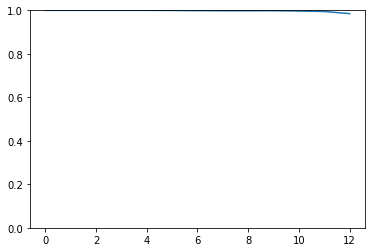

In [22]:
lang='en'
r = []
for j in range(13):
    print(j)
    reps1 = np.array(en_pivot[f'cls_{j}'])
    reps2 = np.array(datasets[l][f'cls_{j}'])
    #score = analysis.cka(reps1.T, reps2.T)
    score = feature_space_linear_cka(reps1, reps2, avg=False)
    r.append(score)
    
sns.lineplot(data=r)
plt.ylim(0,1)

In [38]:
r1 = np.array(en_pivot['cls_1'])
r2 = np.array(datasets['en']['cls_1'])

In [39]:
1 - spatial.distance.cosine(r1[0], r2[0])

0.9999554999752586

In [42]:
1 - spatial.distance.cosine(r1[1], r2[1])

0.9999478096215955

In [48]:
np.dot(r1, r2.T)

array([[185.67416677, 185.67204073, 185.65235543, ..., 185.70385573,
        185.39123675, 185.39976138],
       [185.68367772, 185.72428405, 185.67253018, ..., 185.70619713,
        185.43541347, 185.46344828],
       [185.66148651, 185.68263559, 185.69571431, ..., 185.73655131,
        185.38332944, 185.41037827],
       ...,
       [185.77686487, 185.78697199, 185.81998445, ..., 186.80268237,
        186.25226793, 186.34263831],
       [185.78143669, 185.80676446, 185.79184208, ..., 186.33212424,
        185.92594163, 185.9325615 ],
       [185.66393574, 185.66783337, 185.62471474, ..., 186.32209825,
        185.97232402, 186.07182905]])

In [51]:
analysis.cka_lib.feature_space_linear_cka??

In [52]:
np.linalg.norm(r1.T.dot(r2)) ** 2

77670244261.52657

In [53]:
normalization_x = np.linalg.norm(r1.T.dot(r1))
normalization_y = np.linalg.norm(r2.T.dot(r2))

In [56]:
normalization_x

77670291875.31868

In [57]:
normalization_y

278688.59777307924

In [58]:
normalization_x * normalization_y

77670291875.31868

In [60]:
np.linalg.norm(r1.T.dot(r2)) ** 2 / (normalization_x * normalization_y)

0.9999993869754965

In [1]:
2+2

4

In [157]:
def feature_space_linear_cka(features_x, features_y, debiased=False, avg=True):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """

  if avg:
    features_x = features_x - np.mean(features_x, 0, keepdims=True)
    features_y = features_y - np.mean(features_y, 0, keepdims=True)
  

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  print(f"dot prod sim {dot_product_similarity}")
    
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))
  
  print(f"normalization_x {normalization_x}", f"normalization_y {normalization_y}", f"mult {normalization_x * normalization_y}")
    
  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

In [159]:
feature_space_linear_cka(r1, r2, avg=False)

dot prod sim 77670244261.52657
normalization_x 278699.2094257165 normalization_y 278688.59777307924 mult 77670291875.31868


0.9999993869754965

In [106]:
feature_space_linear_cka(r1, r2, avg=False)

dot prod sim 77670244261.52657
normalization_x 278699.2094257165 normalization_y 278688.59777307924 mult 77670291875.31868


0.9999993869754965

In [109]:
spatial.distance.cosine??

In [108]:
r1.dot(r2.T)

array([[185.67416677, 185.67204073, 185.65235543, ..., 185.70385573,
        185.39123675, 185.39976138],
       [185.68367772, 185.72428405, 185.67253018, ..., 185.70619713,
        185.43541347, 185.46344828],
       [185.66148651, 185.68263559, 185.69571431, ..., 185.73655131,
        185.38332944, 185.41037827],
       ...,
       [185.77686487, 185.78697199, 185.81998445, ..., 186.80268237,
        186.25226793, 186.34263831],
       [185.78143669, 185.80676446, 185.79184208, ..., 186.33212424,
        185.92594163, 185.9325615 ],
       [185.66393574, 185.66783337, 185.62471474, ..., 186.32209825,
        185.97232402, 186.07182905]])

In [114]:
r1 = np.array(en_pivot['cls_1'])
r2 = np.array(datasets['en']['cls_1'])

r1m = np.array(en_pivot['mean_1'])
r2m = np.array(datasets['en']['mean_1'])

In [94]:
m1 = np.mean(r1, 0, keepdims=True)
m2 = np.mean(r2, 0, keepdims=True)

In [100]:
1 - spatial.distance.cosine(r1[10], r2[10])

0.9999739348583452

In [111]:
1 - spatial.distance.correlation(r1[10], r2[10])

0.9999738887415124

In [110]:
1 - spatial.distance.cosine(r1[10] - m1, r2[10] - m2)

0.9788072152975195

In [113]:
r1.max()

3.0037193298339844

In [134]:
from ecco import analysis

In [140]:
analysis.cka_lib.feature_space_linear_cka?

In [148]:
feature_space_linear_cka(r1m, r2m, avg=False)

dot prod sim 17186156435.008125
normalization_x 131076.73607704803 normalization_y 131484.7770753968 mult 17234595422.861282


0.9971894328433782

In [ ]:
ck

In [71]:
feature_space_linear_cka(r1, r2)

0.6146283038711325